In [1]:
import numpy as np
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation,GlobalAveragePooling2D, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import h5py

In [2]:
h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/slices_dataset.h5'
train_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/train_dataset.h5'
test_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/test_dataset.h5'

# Open the existing HDF5 file in read-only mode
data = h5py.File(h5_file, 'r')
samples = data['samples']
labels = data['labels']

train_indices, test_indices = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels, shuffle=True
)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

# Save train dataset to a new HDF5 file
train_data = h5py.File(train_h5_file, 'w')
train_samples = train_data.create_dataset('samples', shape=samples[train_indices].shape, dtype=samples.dtype)
train_labels = train_data.create_dataset('labels', shape=labels[train_indices].shape, dtype=labels.dtype)

# Iterate over train_indices and save the corresponding samples and labels
for i, idx in enumerate(train_indices):
    train_samples[i] = samples[idx]
    train_labels[i] = labels[idx]

train_data.close()

# Save test dataset to a new HDF5 file
test_data = h5py.File(test_h5_file, 'w')
test_samples = test_data.create_dataset('samples', shape=samples[test_indices].shape, dtype=samples.dtype)
test_labels = test_data.create_dataset('labels', shape=labels[test_indices].shape, dtype=labels.dtype)

# Iterate over test_indices and save the corresponding samples and labels
for i, idx in enumerate(test_indices):
    test_samples[i] = samples[idx]
    test_labels[i] = labels[idx]

test_data.close()



In [2]:
h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/slices_dataset.h5'
train_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/train_dataset.h5'
test_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/test_dataset.h5'

class CustomDataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator class
    """
    def __init__(self, h5_file, batch_size=32):
        self.h5_file = h5_file
        self.batch_size = batch_size
        self.data = h5py.File(h5_file, 'r')
        self.samples = self.data['samples']
        self.labels = self.data['labels']
    
    def __len__(self):
        return np.math.ceil(len(self.samples) / self.batch_size)
    
    def __getitem__(self, index):
        """
        Returns a batch of data
        """
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        batch_samples = self.samples[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]

        return batch_samples, batch_labels
    
train_loader = CustomDataGenerator(train_h5_file)
valid_loader = CustomDataGenerator(test_h5_file)

In [6]:
img_shape = (64, 128, 8)

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

for k in [64, 128, 128, 128, 128]:
      model.add(Conv2D(k, (3,3), padding='same'))
      model.add(MaxPooling2D())
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Flatten())
for k in [512, 256, 128]:
      model.add(Dense(k))
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.summary()


slice = Input(shape=img_shape)
pred = model(slice)
model = Model(slice, pred)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
]

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 128, 32)       2336      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 64, 32)       0         
 2D)                                                             
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 64, 32)        0         
                                                                 
 dropout_9 (Dropout)         (None, 32, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 32, 64)       0         
 2D)                                                  

In [7]:
# Train the model
history = model.fit(train_loader, validation_data=valid_loader, epochs=100, callbacks=[early_callback])


Epoch 1/100
346/346 [==============================] - 94s 265ms/step - loss: 2.0489 - accuracy: 0.1626 - precision_1: 0.4514 - recall_1: 0.0130 - val_loss: 1.9253 - val_accuracy: 0.1799 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
346/346 [==============================] - 94s 271ms/step - loss: 1.9457 - accuracy: 0.1887 - precision_1: 0.0286 - recall_1: 9.0351e-05 - val_loss: 1.9253 - val_accuracy: 0.1799 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
346/346 [==============================] - 95s 274ms/step - loss: 1.9698 - accuracy: 0.1460 - precision_1: 0.1719 - recall_1: 0.0020 - val_loss: 1.9384 - val_accuracy: 0.1799 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/100
346/346 [==============================] - 96s 278ms/step - loss: 1.9489 - accuracy: 0.1758 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.8916 - val_accuracy: 0.2836 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100


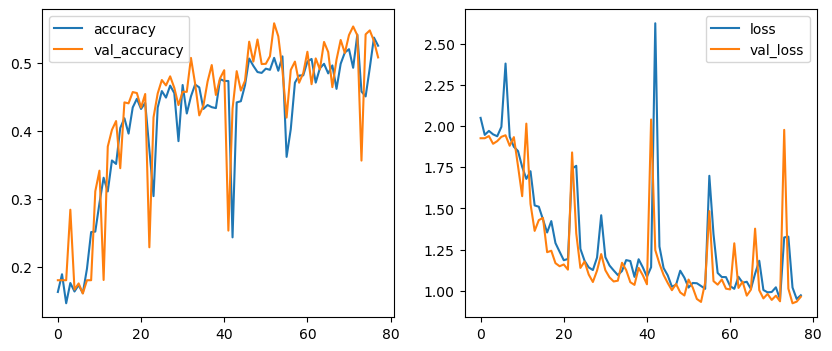

In [8]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [11]:
model.evaluate(valid_loader)


87/87 [==============================] - 8s 88ms/step - loss: 0.9633 - accuracy: 0.5076 - precision_1: 0.8678 - recall_1: 0.3699


[0.9633004665374756,
 0.5075867176055908,
 0.8677965998649597,
 0.36994218826293945]

87/87 [==============================] - 7s 81ms/step


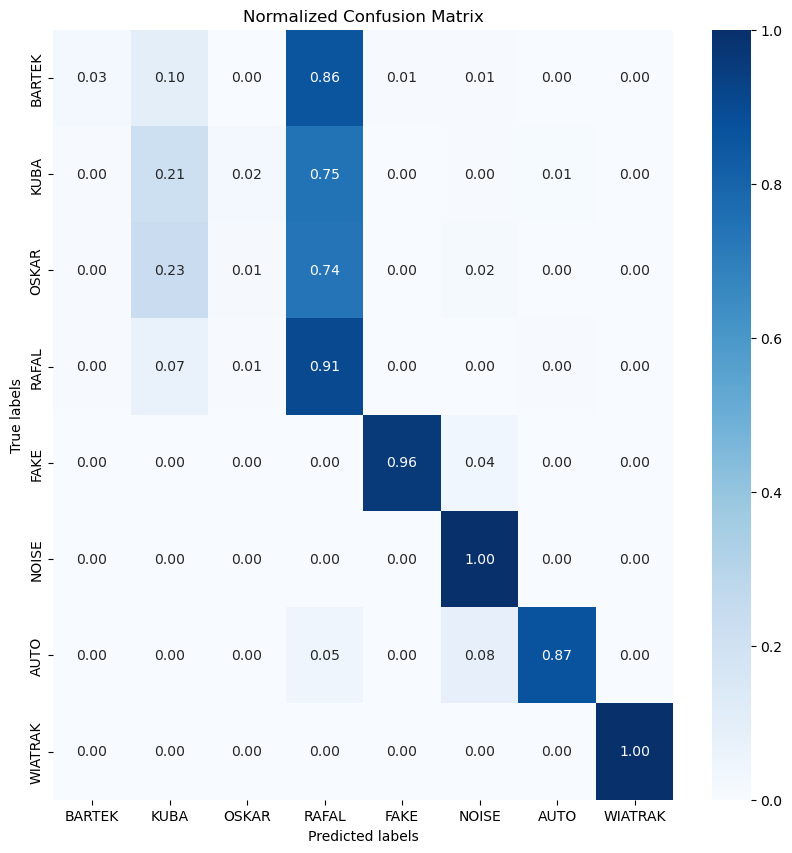

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classes = ['BARTEK', 'KUBA', 'OSKAR', 'RAFAL', 'FAKE', 'NOISE', 'AUTO', 'WIATRAK']

# Assuming you have already trained the model
y_pred = model.predict(valid_loader)
y_pred = np.argmax(y_pred, axis=1)
y_true = valid_loader.labels
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()